In [4]:
import qiime2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from os import path
from subprocess import PIPE,Popen
from Bio.KEGG import REST
%matplotlib inline

### Filter biom tables

In [111]:
!mkdir filtered_tables/16SrRNA filtered_tables/ITS1 

for marker in ['16SrRNA','ITS1']:
    
    inf = 'dada/%s/table.qza' % marker
    tempf = 'filtered_tables/%s/temp.qza' % marker
    outf = 'filtered_tables/%s/filtered_table.qza' % marker
    outf_da = 'filtered_tables/%s/filtered_table.D_VS_A.qza' % marker
    outf_hh = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qza' % marker
    outf_hh_v = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qzv' % marker
    outf_hh_4 = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.l4.qza' % marker
    outf_hetro =  'filtered_tables/%s/filtered_table.hetero.qza' % marker
    outf_homo =  'filtered_tables/%s/filtered_table.homo.qza' % marker
    outf_shrub =  'filtered_tables/%s/filtered_table.shrub.qza' % marker
    outf_intershrub =  'filtered_tables/%s/filtered_table.intershrub.qza' % marker
    taxonomy = 'dada/%s/taxonomy.qza' % marker
    metadata = '%s_metadata.tsv' % marker
    
    !qiime taxa filter-table \
      --i-table $inf \
      --i-taxonomy $taxonomy \
      --p-exclude mitochondria,chloroplast \
      --o-filtered-table $tempf
    
    !qiime feature-table filter-features \
      --i-table $tempf \
      --p-min-frequency 10 \
      --o-filtered-table $tempf
    
    !qiime feature-table filter-features \
      --i-table $tempf \
      --p-min-samples 2 \
      --o-filtered-table $outf
    
    !qiime feature-table filter-samples \
      --i-table $outf \
      --m-metadata-file $metadata \
      --p-where "[Experiment]='H_VS_O' AND [S] NOT IN ('AS3059','AS3009','AS3000','ITS-AS3027','ITS-AS3043')" \
      --o-filtered-table $outf_hh
    
    !qiime feature-table summarize \
      --i-table $outf_hh \
      --o-visualization $outf_hh_v \
      --m-sample-metadata-file $metadata
    
    !qiime feature-table filter-samples \
      --i-table $outf \
      --m-metadata-file $metadata \
      --p-where "[Experiment]='D_VS_L'" \
      --o-filtered-table $outf_da
    
    !qiime feature-table filter-samples \
      --i-table $outf \
      --m-metadata-file $metadata \
      --p-where "[Experiment]='H_VS_O' AND [Geodiversity]='Heterogenous' AND [S] NOT IN ('AS3059','AS3009','AS3000','ITS-AS3027','ITS-AS3043')" \
      --o-filtered-table $outf_hetro
    
    !qiime feature-table filter-samples \
      --i-table $outf \
      --m-metadata-file $metadata \
      --p-where "[Experiment]='H_VS_O' AND [Geodiversity]='Homogenous' AND [S] NOT IN ('AS3059','AS3009','AS3000','ITS-AS3027','ITS-AS3043')" \
      --o-filtered-table $outf_homo
    
    !qiime feature-table filter-samples \
      --i-table $outf \
      --m-metadata-file $metadata \
      --p-where "[Experiment]='H_VS_O' AND [Niche]='Shrub' AND [S] NOT IN ('AS3059','AS3009','AS3000','ITS-AS3027','ITS-AS3043')" \
      --o-filtered-table $outf_shrub
    
    !qiime feature-table filter-samples \
      --i-table $outf \
      --m-metadata-file $metadata \
      --p-where "[Experiment]='H_VS_O' AND [Niche]='Intershrub' AND [S] NOT IN ('AS3059','AS3009','AS3000','ITS-AS3027','ITS-AS3043')" \
      --o-filtered-table $outf_intershrub
    

    !qiime taxa collapse \
      --i-table $outf_hh \
      --i-taxonomy $taxonomy \
      --p-level 4 \
      --o-collapsed-table $outf_hh_4
    

mkdir: cannot create directory ‘filtered_tables/16SrRNA’: File exists
mkdir: cannot create directory ‘filtered_tables/ITS1’: File exists
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: filtered_tables/16SrRNA/temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: filtered_tables/16SrRNA/temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as p

### Order level relative abundances

In [12]:
narrow = pd.DataFrame(columns = ['marker','taxon','order','Geodiversity','niche','Relative Abundance'])

for marker in ['16SrRNA','ITS1']:
    
    outf_hh_4 = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.l4.qza' % marker
    metadata = pd.read_csv('%s_metadata.tsv' % marker, index_col=0,sep='\t')
    
    !qiime feature-table relative-frequency \
        --i-table $outf_hh_4 \
        --o-relative-frequency-table temp.qza
    
    a = qiime2.Artifact.load('temp.qza')
    table = a.view(pd.DataFrame).transpose()
    
    for taxon in table.index.tolist():
        for col in table:
            geo = 'Heterogeneous'
            if metadata.at[col,'Geodiversity'] == 'Homogenous':
                geo = 'Homogeneous'
            niche = metadata.at[col,'Niche']
            narrow.loc[len(narrow)] = [marker,taxon,taxon.split('__')[-1],geo,niche,table.at[taxon,col]]
    
    !rm temp.qza


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[RelativeFrequency] to: temp.qza


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[RelativeFrequency] to: temp.qza


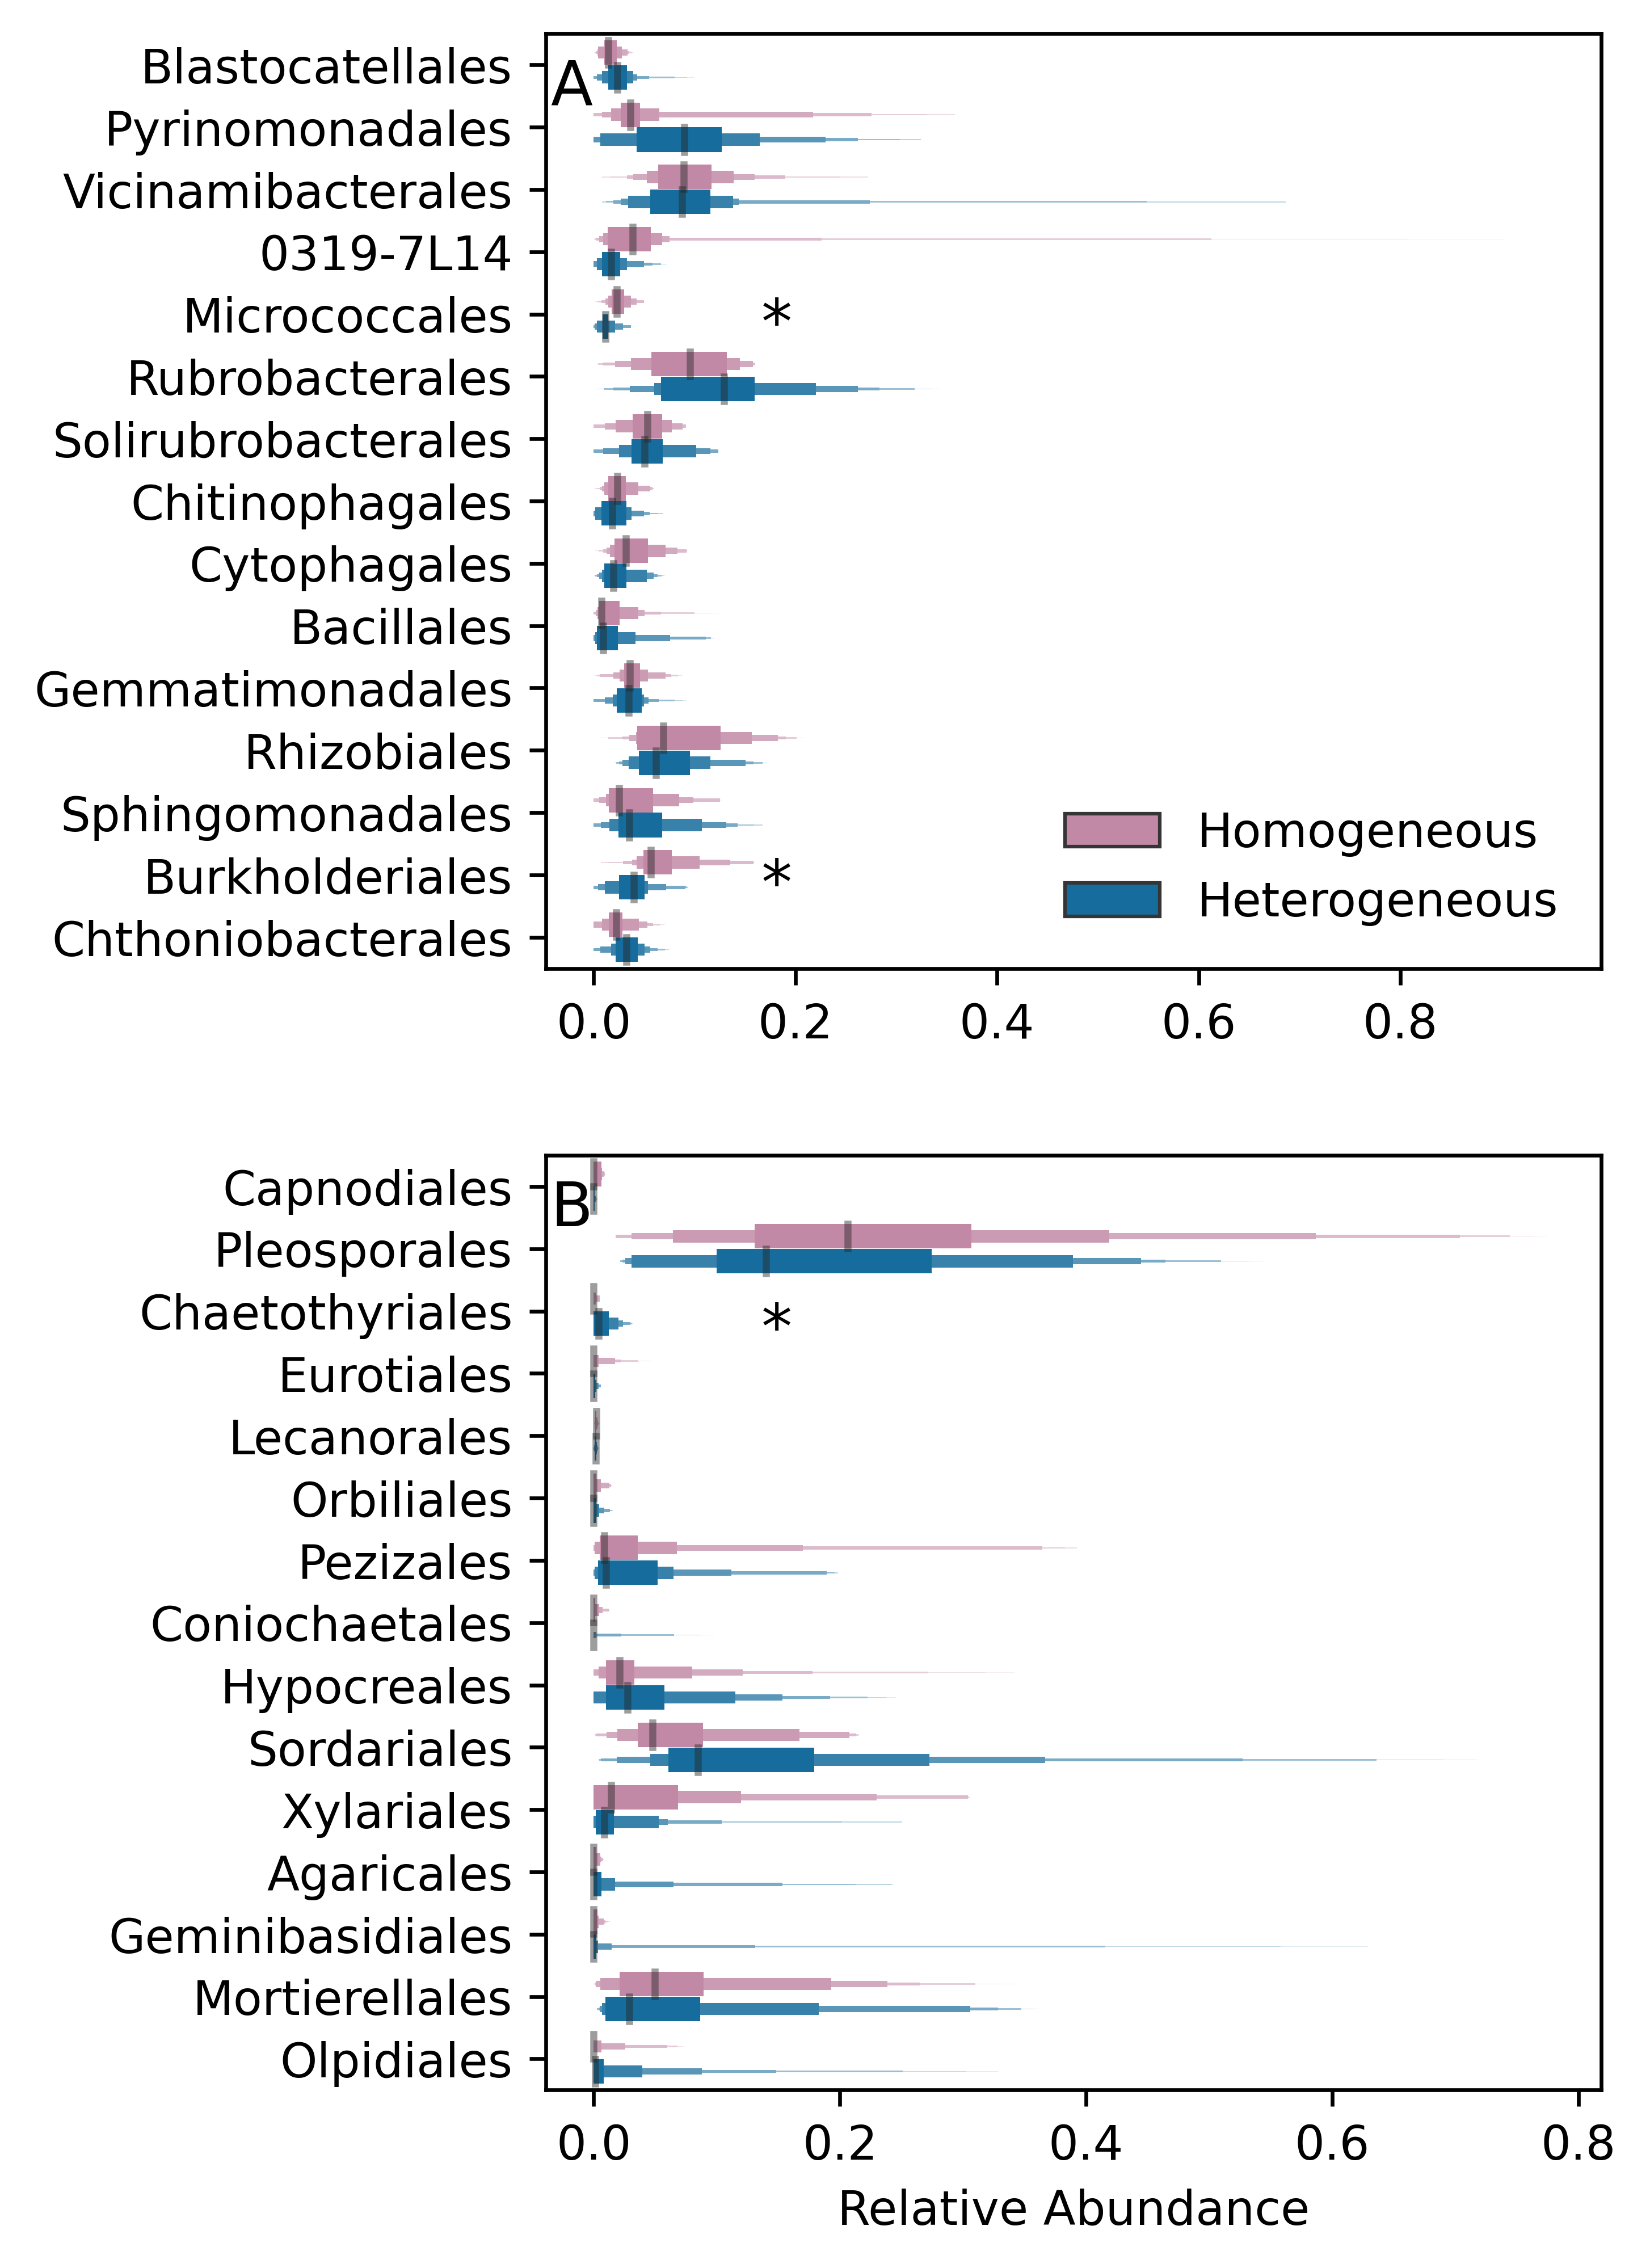

In [13]:
fig, axes = plt.subplots(nrows = 2, dpi=600, figsize=(4,8))
indices = [0,1]
ax_labels = ['A','B']


for marker in ['16SrRNA','ITS1']:
    
    averages = {}

    for order in set(narrow.loc[narrow.marker==marker].order):
        if 'NA' in order:
            continue
        averages[order] = np.average(narrow.loc[narrow.order==order]['Relative Abundance'])
        
        
    top_orders = [i[0] for i in sorted(averages.items(), key=lambda h: h[1], reverse=True)[:15]]
    
    ax = axes[indices.pop(0)]
    
    a = narrow.loc[narrow.order.isin(top_orders)]
    
    a.pivot_table(index=['order','Geodiversity']).to_csv('%s_top_orders.tsv' % marker,sep='\t')
    
    sns.boxenplot(x='Relative Abundance',y='order',data=a,hue='Geodiversity',ax=ax,palette=['#cc7fa7','#0072b2'],showfliers=False)

    if len(indices) == 0:
        ax.legend().remove()
    else:
        ax.set_xlabel('')
        
    ax.set_ylabel('')
    ax.annotate(ax_labels.pop(0),xy=(0,1),xycoords="axes fraction",xytext=(1,-5),textcoords="offset points",ha="left",va="top",size=13)
    
    if marker == '16SrRNA':
        ax.legend(frameon=False,loc=4)
        ax.annotate('*',xy=(0.2,0.745),xycoords="axes fraction",xytext=(1,-5),textcoords="offset points",ha="left",va="top",size=13)
        ax.annotate('*',xy=(0.2,0.145),xycoords="axes fraction",xytext=(1,-5),textcoords="offset points",ha="left",va="top",size=13)
    else:
        ax.annotate('*',xy=(0.2,0.87),xycoords="axes fraction",xytext=(1,-5),textcoords="offset points",ha="left",va="top",size=13)
        
        
plt.savefig('rel_abund.png',bbox_inches='tight')

In [114]:
from scipy.stats import mannwhitneyu as mwu
from statsmodels.stats.multitest import multipletests

mw_results = pd.DataFrame(columns=['Order','u','p'])

for order in set(narrow.order):
    a = narrow.loc[((narrow.order == order) & (narrow.Geodiversity == 'Homogeneous'))]['Relative Abundance']
    b = narrow.loc[((narrow.order == order) & (narrow.Geodiversity == 'Heterogeneous'))]['Relative Abundance']
    mw_results.loc[len(mw_results)] = [order]+list(mwu(a,b))
mw_results['q'] = list(multipletests(mw_results.p,method='fdr_bh'))[1]   
mw_results.loc[mw_results.q<0.05]

,Order,u,p,q
39,Burkholderiales,156.0,0.000096,0.005438
40,Micrococcales,131.0,0.000017,0.001411
103,Rhodothermales,266.0,0.001102,0.046848
146,Chaetothyriales,172.5,0.000014,0.001411


### Rarefaction curves

In [115]:
!mkdir -p bars_and_alpha_rarefaction/16SrRNA bars_and_alpha_rarefaction/ITS1 

for marker in ['16SrRNA','ITS1']:
    
    table = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qza' % marker
    taxonomy = 'dada/%s/taxonomy.qza' % marker
    tree = 'dada/%s/rooted-tree.qza' % marker
    barplot = 'bars_and_alpha_rarefaction/%s/barplot.qza' % marker
    alpha_rarefaction_curve = 'bars_and_alpha_rarefaction/%s/alpha-rarefaction.qzv' % marker
    metadata = '%s_metadata.tsv' % marker
    
    !qiime taxa barplot \
      --i-table $table \
      --i-taxonomy $taxonomy \
      --m-metadata-file $metadata \
      --o-visualization $barplot
    
    !qiime diversity alpha-rarefaction \
      --i-table $table \
      --i-phylogeny $tree \
      --p-max-depth 6000 \
      --m-metadata-file $metadata \
      --o-visualization $alpha_rarefaction_curve

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: bars_and_alpha_rarefaction/16SrRNA/barplot.qza.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: bars_and_alpha_rarefaction/16SrRNA/alpha-rarefaction.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: bars_and_alpha_rarefaction/ITS1/barplot.qza.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/

### Diversity indices

In [116]:
!mkdir -p diversity

for marker in ['16SrRNA','ITS1']:
    
    depth = 3200
    if marker == 'ITS1':
        depth = 3000
    
    table = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qza' % marker
    tree = 'dada/%s/rooted-tree.qza' % marker
    outdir = 'diversity/%s' % marker
    metadata = '%s_metadata.tsv' % marker
    rare_table = 'diversity/%s/rarefied_table.qza' % marker
    matrix_weighted = 'diversity/%s/weighted_unifrac_distance_matrix.qza' % marker
    matrix_unweighted = 'diversity/%s/unweighted_unifrac_distance_matrix.qza' % marker
    pcoa_weighted = 'diversity/%s/weighted_unifrac_pcoa_results.qza' % marker
    pcoa_unweighted = 'diversity/%s/unweighted_unifrac_pcoa_results.qza' % marker
    biplot_weighted = 'diversity/%s/weighted_unifrac_biplot_results.qza' % marker
    biplot_unweighted = 'diversity/%s/unweighted_unifrac_biplot_results.qza' % marker
    biplot_weighted_qzv = 'diversity/%s/weighted_unifrac_biplot_results.qzv' % marker
    biplot_unweighted_qzv = 'diversity/%s/unweighted_unifrac_biplot_results.qzv' % marker
    
    !qiime diversity core-metrics-phylogenetic \
      --i-phylogeny $tree \
      --i-table $table \
      --p-sampling-depth $depth \
      --m-metadata-file $metadata \
      --output-dir $outdir

    !qiime diversity pcoa \
      --i-distance-matrix $matrix_weighted \
      --p-number-of-dimensions 3 \
      --o-pcoa $pcoa_weighted

    !qiime diversity pcoa \
      --i-distance-matrix $matrix_unweighted \
      --p-number-of-dimensions 3 \
      --o-pcoa $pcoa_unweighted
    
    !qiime feature-table relative-frequency \
      --i-table $rare_table \
      --o-relative-frequency-table temp.qza 

    !qiime diversity pcoa-biplot \
      --i-pcoa $pcoa_weighted \
      --i-features temp.qza \
      --o-biplot $biplot_weighted
    
    !qiime diversity pcoa-biplot \
      --i-pcoa $pcoa_unweighted \
      --i-features temp.qza \
      --o-biplot $biplot_unweighted

    !qiime emperor biplot \
      --m-sample-metadata-file $metadata \
      --i-biplot $biplot_unweighted \
      --p-number-of-features 6 \
      --o-visualization $biplot_unweighted_qzv

    !qiime emperor biplot \
      --m-sample-metadata-file $metadata \
      --i-biplot $biplot_weighted \
      --p-number-of-features 6 \
      --o-visualization $biplot_weighted_qzv

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: diversity/16SrRNA/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: diversity/16SrRNA/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/16SrRNA/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/16SrRNA/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/16SrRNA/evenness_vector.qza
Saved DistanceMatrix to: diversity/16SrRNA/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/16SrRNA/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/16SrRNA/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity/16SrRNA/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity/16SrRNA/unweighted_unifrac_pcoa_resul

### Diversity indices, each niche separately

In [117]:
for marker in ['16SrRNA','ITS1']:
    
    for niche in ['shrub','intershrub']:
        
        d = 'diversity_%s' % niche
        !mkdir -p $d
    
        depth = 3200
        if marker == 'ITS1':
            depth = 3000

        table = 'filtered_tables/%s/filtered_table.%s.qza' % (marker,niche)
        tree = 'dada/%s/rooted-tree.qza' % marker
        outdir = 'diversity_%s/%s' % (niche,marker)
        metadata = '%s_metadata.tsv' % marker
        rare_table = 'diversity_%s/%s/rarefied_table.qza' % (niche,marker)
        pcoa_weighted = 'diversity_%s/%s/weighted_unifrac_pcoa_results.qza' % (niche,marker)
        pcoa_unweighted = 'diversity_%s/%s/unweighted_unifrac_pcoa_results.qza' % (niche,marker)
        biplot_weighted = 'diversity_%s/%s/weighted_unifrac_biplot_results.qza' % (niche,marker)
        biplot_unweighted = 'diversity_%s/%s/unweighted_unifrac_biplot_results.qza' % (niche,marker)

        !qiime diversity core-metrics-phylogenetic \
          --i-phylogeny $tree \
          --i-table $table \
          --p-sampling-depth $depth \
          --m-metadata-file $metadata \
          --output-dir $outdir

        !qiime feature-table relative-frequency \
          --i-table $rare_table \
          --o-relative-frequency-table temp.qza 

        !qiime diversity pcoa-biplot \
          --i-pcoa $pcoa_weighted \
          --i-features temp.qza \
          --o-biplot $biplot_weighted

        !qiime diversity pcoa-biplot \
          --i-pcoa $pcoa_unweighted \
          --i-features temp.qza \
          --o-biplot $biplot_unweighted

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: diversity_shrub/16SrRNA/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: diversity_shrub/16SrRNA/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity_shrub/16SrRNA/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: diversity_shrub/16SrRNA/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity_shrub/16SrRNA/evenness_vector.qza
Saved DistanceMatrix to: diversity_shrub/16SrRNA/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity_shrub/16SrRNA/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity_shrub/16SrRNA/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity_shrub/16SrRNA/bray_curtis_distance_matrix.qza
Saved PCoAResul

### Diversity, each geodiversity level separately

In [82]:
for marker in ['16SrRNA','ITS1']:
    
    for niche in ['homo','hetero']:
        
        d = 'diversity_%s' % niche
        !mkdir -p $d
    
        depth = 3200
        if marker == 'ITS1':
            depth = 3000

        table = 'filtered_tables/%s/filtered_table.%s.qza' % (marker,niche)
        tree = 'dada/%s/rooted-tree.qza' % marker
        outdir = 'diversity_%s/%s' % (niche,marker)
        metadata = '%s_metadata.tsv' % marker
        rare_table = 'diversity_%s/%s/rarefied_table.qza' % (niche,marker)
        pcoa_weighted = 'diversity_%s/%s/weighted_unifrac_pcoa_results.qza' % (niche,marker)
        pcoa_unweighted = 'diversity_%s/%s/unweighted_unifrac_pcoa_results.qza' % (niche,marker)
        biplot_weighted = 'diversity_%s/%s/weighted_unifrac_biplot_results.qza' % (niche,marker)
        biplot_unweighted = 'diversity_%s/%s/unweighted_unifrac_biplot_results.qza' % (niche,marker)

        !qiime diversity core-metrics-phylogenetic \
          --i-phylogeny $tree \
          --i-table $table \
          --p-sampling-depth $depth \
          --m-metadata-file $metadata \
          --output-dir $outdir

        !qiime feature-table relative-frequency \
          --i-table $rare_table \
          --o-relative-frequency-table temp.qza 

        !qiime diversity pcoa-biplot \
          --i-pcoa $pcoa_weighted \
          --i-features temp.qza \
          --o-biplot $biplot_weighted

        !qiime diversity pcoa-biplot \
          --i-pcoa $pcoa_unweighted \
          --i-features temp.qza \
          --o-biplot $biplot_unweighted

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: diversity_homo/16SrRNA/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: diversity_homo/16SrRNA/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity_homo/16SrRNA/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: diversity_homo/16SrRNA/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity_homo/16SrRNA/evenness_vector.qza
Saved DistanceMatrix to: diversity_homo/16SrRNA/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity_homo/16SrRNA/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity_homo/16SrRNA/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity_homo/16SrRNA/bray_curtis_distance_matrix.qza
Saved PCoAResults to: di

### PCoA and BiPlot plots

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifyi

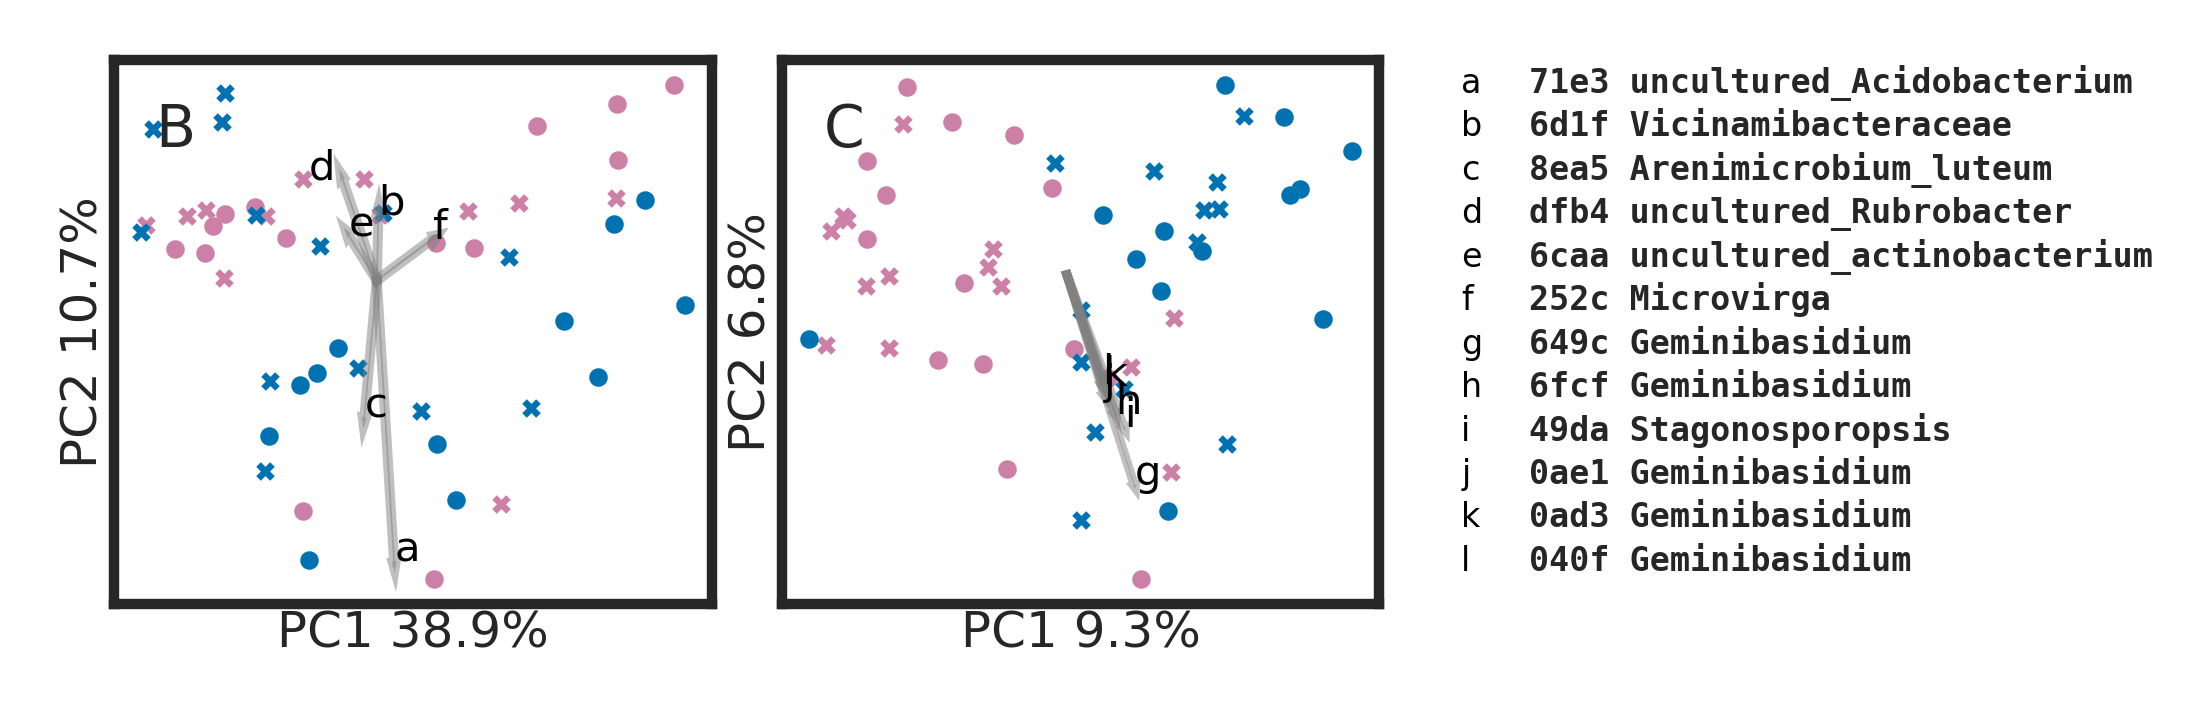

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.spatial.distance import euclidean
%matplotlib inline

def parse_biplot(qza): ### Unzipping qza biplots
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/ordination.txt'
    lines = open(inf,'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    biplot_skiprows = 7
    biplot_skipfoot = len(open(inf,'r').read().split('Site')[1].splitlines()) + 1
    pcoa_skiprows = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pcoa_skipfoot = 4
    pcoa = pd.read_csv(inf, index_col=0, skiprows=pcoa_skiprows, skipfooter=pcoa_skipfoot, header=None, sep='\t')
    biplot = pd.read_csv(inf, index_col=0, skiprows=biplot_skiprows, skipfooter=biplot_skipfoot, header=None, sep='\t')
    nan_cols = []
    for col in biplot:
        if np.isnan(biplot[col].tolist()[0]):
            nan_cols.append(col)
    if len(nan_cols) > 0:
        biplot = biplot.drop(labels=nan_cols,axis=1)
    !rm -r $digest
    return  pcoa, biplot, Eigvals, Proportion

def get_arrow_coords(axis,axis2,num,biplot): ### Geting coordinats for arrows
    arrow_data = []
    origin = np.zeros_like(biplot.columns)
    biplot['importance'] = biplot.apply(euclidean, axis=1, args=(origin,))
    biplot.sort_values('importance', inplace=True, ascending=False)
    for taxon in biplot.index.tolist()[:num].copy():
        arrow_data.append([taxon,biplot.at[taxon,axis],biplot.at[taxon,axis2]])
    return arrow_data

colora = {
    'Heterogenous': '#0072b2',
    'Homogenous': '#cc7fa7'
}

marka = {
    'Shrub': 'o',
    'Intershrub': 'X'
}

def sub(ordination,metadata,ax):
    for geo in set(metadata.Geodiversity):
        for niche in set(metadata.Niche):
            color = colora[geo]
            marker = marka[niche]
            size = 5
            data = ordination.loc[
                ordination.index.isin(metadata.loc[
                    ((metadata.Niche == niche) & (metadata.Geodiversity == geo))
                ].index)
            ]
            sns.scatterplot(x=x,y=y,
                            data=data,
                            ax=ax,
                            legend=False,
                            color=color,
                            marker=marker,
                            s=size,
                            linewidth=0.01)


z=6 ### Number of features to plot

fig=plt.figure(constrained_layout=True,dpi=600,figsize=(3.3,1.2))
fig.set_constrained_layout_pads(w_pad=0, h_pad=0)
gs = GridSpec(1, 3, width_ratios=[3,3, 1], wspace=0.15)
axes = []
for ax in gs:
    axes.append(fig.add_subplot(ax))

sns.set_style("white")
sns.axes_style("white")
sns.axes_style("white")
    
j=0

letter = 'a'
ax_labels = ['B','C']
arrow_labels_legend = {}
for marker in ['16SrRNA','ITS1']:
    metadata = pd.read_csv('%s_metadata.tsv' % marker, sep='\t', index_col=0)
    qza = 'dada/%s/taxonomy.qza' % marker
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/taxonomy.tsv'
    taxa = pd.read_csv(inf,index_col=0,sep='\t')
    !rm -r $digest
    for unifrac in ['weighted_unifrac','unweighted_unifrac']:
        if marker == '16SrRNA' and unifrac == 'unweighted_unifrac':
            continue
        if marker == 'ITS1' and unifrac == 'weighted_unifrac':
            continue
        qza = 'diversity/%s/%s_biplot_results.qza' % (marker,unifrac)
        ordination, biplot, Eigvals, Proportion = parse_biplot(qza)
        
        x=1 ### axis to show
        y=2 ### axis to show
        ax = axes[j]
        j+=1
        sub(ordination,metadata,ax)
        
        ylim = ax.get_ylim()

        arrow_data = get_arrow_coords(x,y,z,biplot)
        
        for arrow in arrow_data:
            arrow_x,text_x = arrow[1],arrow[1]
            arrow_y, text_y = arrow[2], arrow[2]
            if marker == '16SrRNA':
                arrow_y, text_y = arrow[2]*0.3, arrow[2]*0.3
                arrow_x,text_x = arrow[1]*0.3,arrow[1]*0.3
            if marker == 'ITS1':
                arrow_y, text_y = arrow[2]*4, arrow[2]*4
                arrow_x,text_x = arrow[1]*4,arrow[1]*4
            ax.arrow(0, 0, arrow_x, arrow_y, fc='gray',ec='gray',alpha=0.5)
            t = taxa.at[arrow[0],'Taxon'].split(';')[-1]
            k = -2
            while t=='NA':
                t = taxa.at[arrow[0],'Taxon'].split(';')[k]
                k-=1
            T = t.split('__')[1]
            arrow_labels_legend[letter] = arrow[0][:4]+' '+T
            if letter == 'd':
                text_x -= 0.02
            ax.text(text_x, text_y, letter, fontdict={'fontsize': 5, 'color':'black'})
            letter = chr(ord(letter) + 1)

        ax.tick_params(axis='both', length=0, pad=0)       
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_ylabel('PC%i %.1f%%' % (y, Proportion[y-1]*100.0),fontdict={'fontsize': 6})
        ax.set_xlabel('PC%i %.1f%%' % (x, Proportion[x-1]*100.0),fontdict={'fontsize': 6})
        ax.xaxis.set_label_coords(0.5, -0.01)
        ax.yaxis.set_label_coords(-0.01, 0.5)
        ax.autoscale(enable=True, axis='both', tight=None)
        ax.annotate(ax_labels.pop(0),xy=(0,1),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=7)
        #ax.set_xlim(-0.225,0.21)

ax = axes[j]
sns.axes_style("white")
j+=1
ax.tick_params(axis='both', length=0, pad=0)       
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylim(0,1)
ax.set_xlim(0,0.25)

legend = sorted(list(arrow_labels_legend.items()))
y = 0.95
#for c in colora:
#    for m in marka:
#        sns.scatterplot([0.03],[y],marker=marka[m],color=colora[c],ax=ax,s=15,legend=False)
#        text = 'Heterogeneous'
#        if c == 'Homogenous':
#            text = 'Homogeneous'
#        n = 'Inter-patch'
#        if m == 'Shrub':
#            n = 'Shrubby patch'
#        ax.text(0.1,y-0.01,"%s %s" % (text,n),fontdict={'size':4})
#        y -= 0.08
for i in legend:
    ax.text(0.015,y-0.01,i[0],fontdict={'size':4,'color':'black'})
    asv = i[1]
    ax.text(0.1,y-0.01,asv,fontdict={'size':4,'family':'monospace','weight':'semibold'})
    y -= 0.08

for a in ['top','bottom','left','right']:
    ax.spines[a].set_visible(False)

plt.savefig('PCoA.png',bbox_inches='tight')

### Logistic regression, ASVs

In [393]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from qiime2 import Artifact
from random import randint

!mkdir -p logistic_regression/16SrRNA logistic_regression/ITS1

for marker in ['16SrRNA','ITS1']:
    
    metadata = pd.read_csv('%s_metadata.tsv' % marker,sep='\t',index_col=0)
    X = Artifact.load('diversity/%s/rarefied_table.qza' % marker).view(pd.DataFrame)
    coefficients = pd.DataFrame(index=X.columns)
    R2 = []
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    y = [metadata.at[i,'Geodiversity'] for i in X.index]
    
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=randint(2,2000),stratify=y)

        regr = LogisticRegression()
        regr.fit(X_train,y_train)
        R2.append(regr.score(X_test,y_test))
        coefficients[i] = regr.coef_[0]
        
    coefficients.to_csv('logistic_regression/%s/coefficients.tsv' % marker, sep='\t')
    with open('logistic_regression/%s/regression_coefficients.txt' % marker, 'wt') as hndl:
        for r in R2:
            hndl.write('%.8f\n' % r)


### PiCRUST analysis

In [ ]:
from Bio import SeqIO
import pandas as pd

!mkdir -p picrust/16SrRNA/

# ASV sequences
qza = 'dada/16SrRNA/rep-seqs.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/dna-sequences.fasta'
repseqs = SeqIO.to_dict(SeqIO.parse(inf,'fasta'))
!rm -r $digest 

#get biom
qza = 'diversity/16SrRNA/rarefied_table.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
inf = digest + '/data/feature-table.biom'
a = !cp $inf picrust/table.biom

# get fasta
outf = 'temp.%s' % digest
a = !biom convert -i $inf -o $outf --to-tsv
biom = pd.read_table(outf,skiprows=1,index_col=0)
    
with open('picrust/16SrRNA/repseq.fasta','wt') as hndl:
    for ind in biom.index:
        r = repseqs[ind]
        hndl.write('>'+r.id+'\n')
        hndl.write(str(r.seq).replace('N','')+'\n')

!rm -r $digest
!rm $outf

!picrust2_pipeline.py \
    -s picrust/16SrRNA/repseq.fasta \
    -i picrust/16SrRNA/table.biom \
    -o picrust/16SrRNA/outputs -p 7

!add_descriptions.py \
    -i picrust/16SrRNA/outputs/EC_metagenome_out/pred_metagenome_unstrat.tsv.gz \
    -m EC \
    -o picrust/16SrRNA/outputs/EC_metagenome_out/pred_metagenome_unstrat_descrip.tsv.gz

!add_descriptions.py \
    -i picrust/16SrRNA/outputs/pathways_out/path_abun_unstrat.tsv.gz \
    -m METACYC \
    -o picrust/16SrRNA/outputs/pathways_out/path_abun_unstrat_descrip.tsv.gz

### Logistic regression - genes from PiCRUST

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from qiime2 import Artifact
from random import randint

for marker in ['16SrRNA']:
    
    metadata = pd.read_csv('%s_metadata.tsv' % marker,sep='\t',index_col=0)
    gene_table = 'picrust/16SrRNA/outputs/KO_metagenome_out/pred_metagenome_unstrat.tsv.gz'
    gene_X = pd.read_csv(gene_table, index_col=0,sep='\t').transpose()
    coefficients = pd.DataFrame(index=gene_X.columns)
    R2 = []
    scaler = StandardScaler()
    scaler.fit(gene_X)
    gene_X_scaled = scaler.transform(gene_X)
    y = [metadata.at[i,'Geodiversity'] for i in gene_X.index]
    
    for i in range(100):
        
        randseed = randint(2,2000)
        
        X_train, X_test, y_train, y_test = train_test_split(gene_X_scaled, y, test_size=0.5, random_state=randseed,stratify=y)

        regr = LogisticRegression()
        regr.fit(X_train,y_train)
        
        R2.append(regr.score(X_test,y_test))
        coefficients[i] = regr.coef_[0]
            
    coefficients.to_csv('picrust/%s/coefficients.tsv' % marker, sep='\t')
    with open('picrust/%s/regression_coefficients.txt' % marker, 'wt') as hndl:
        for r in R2:
            hndl.write('%.8f\n' % r)

### Loogistic regression figure

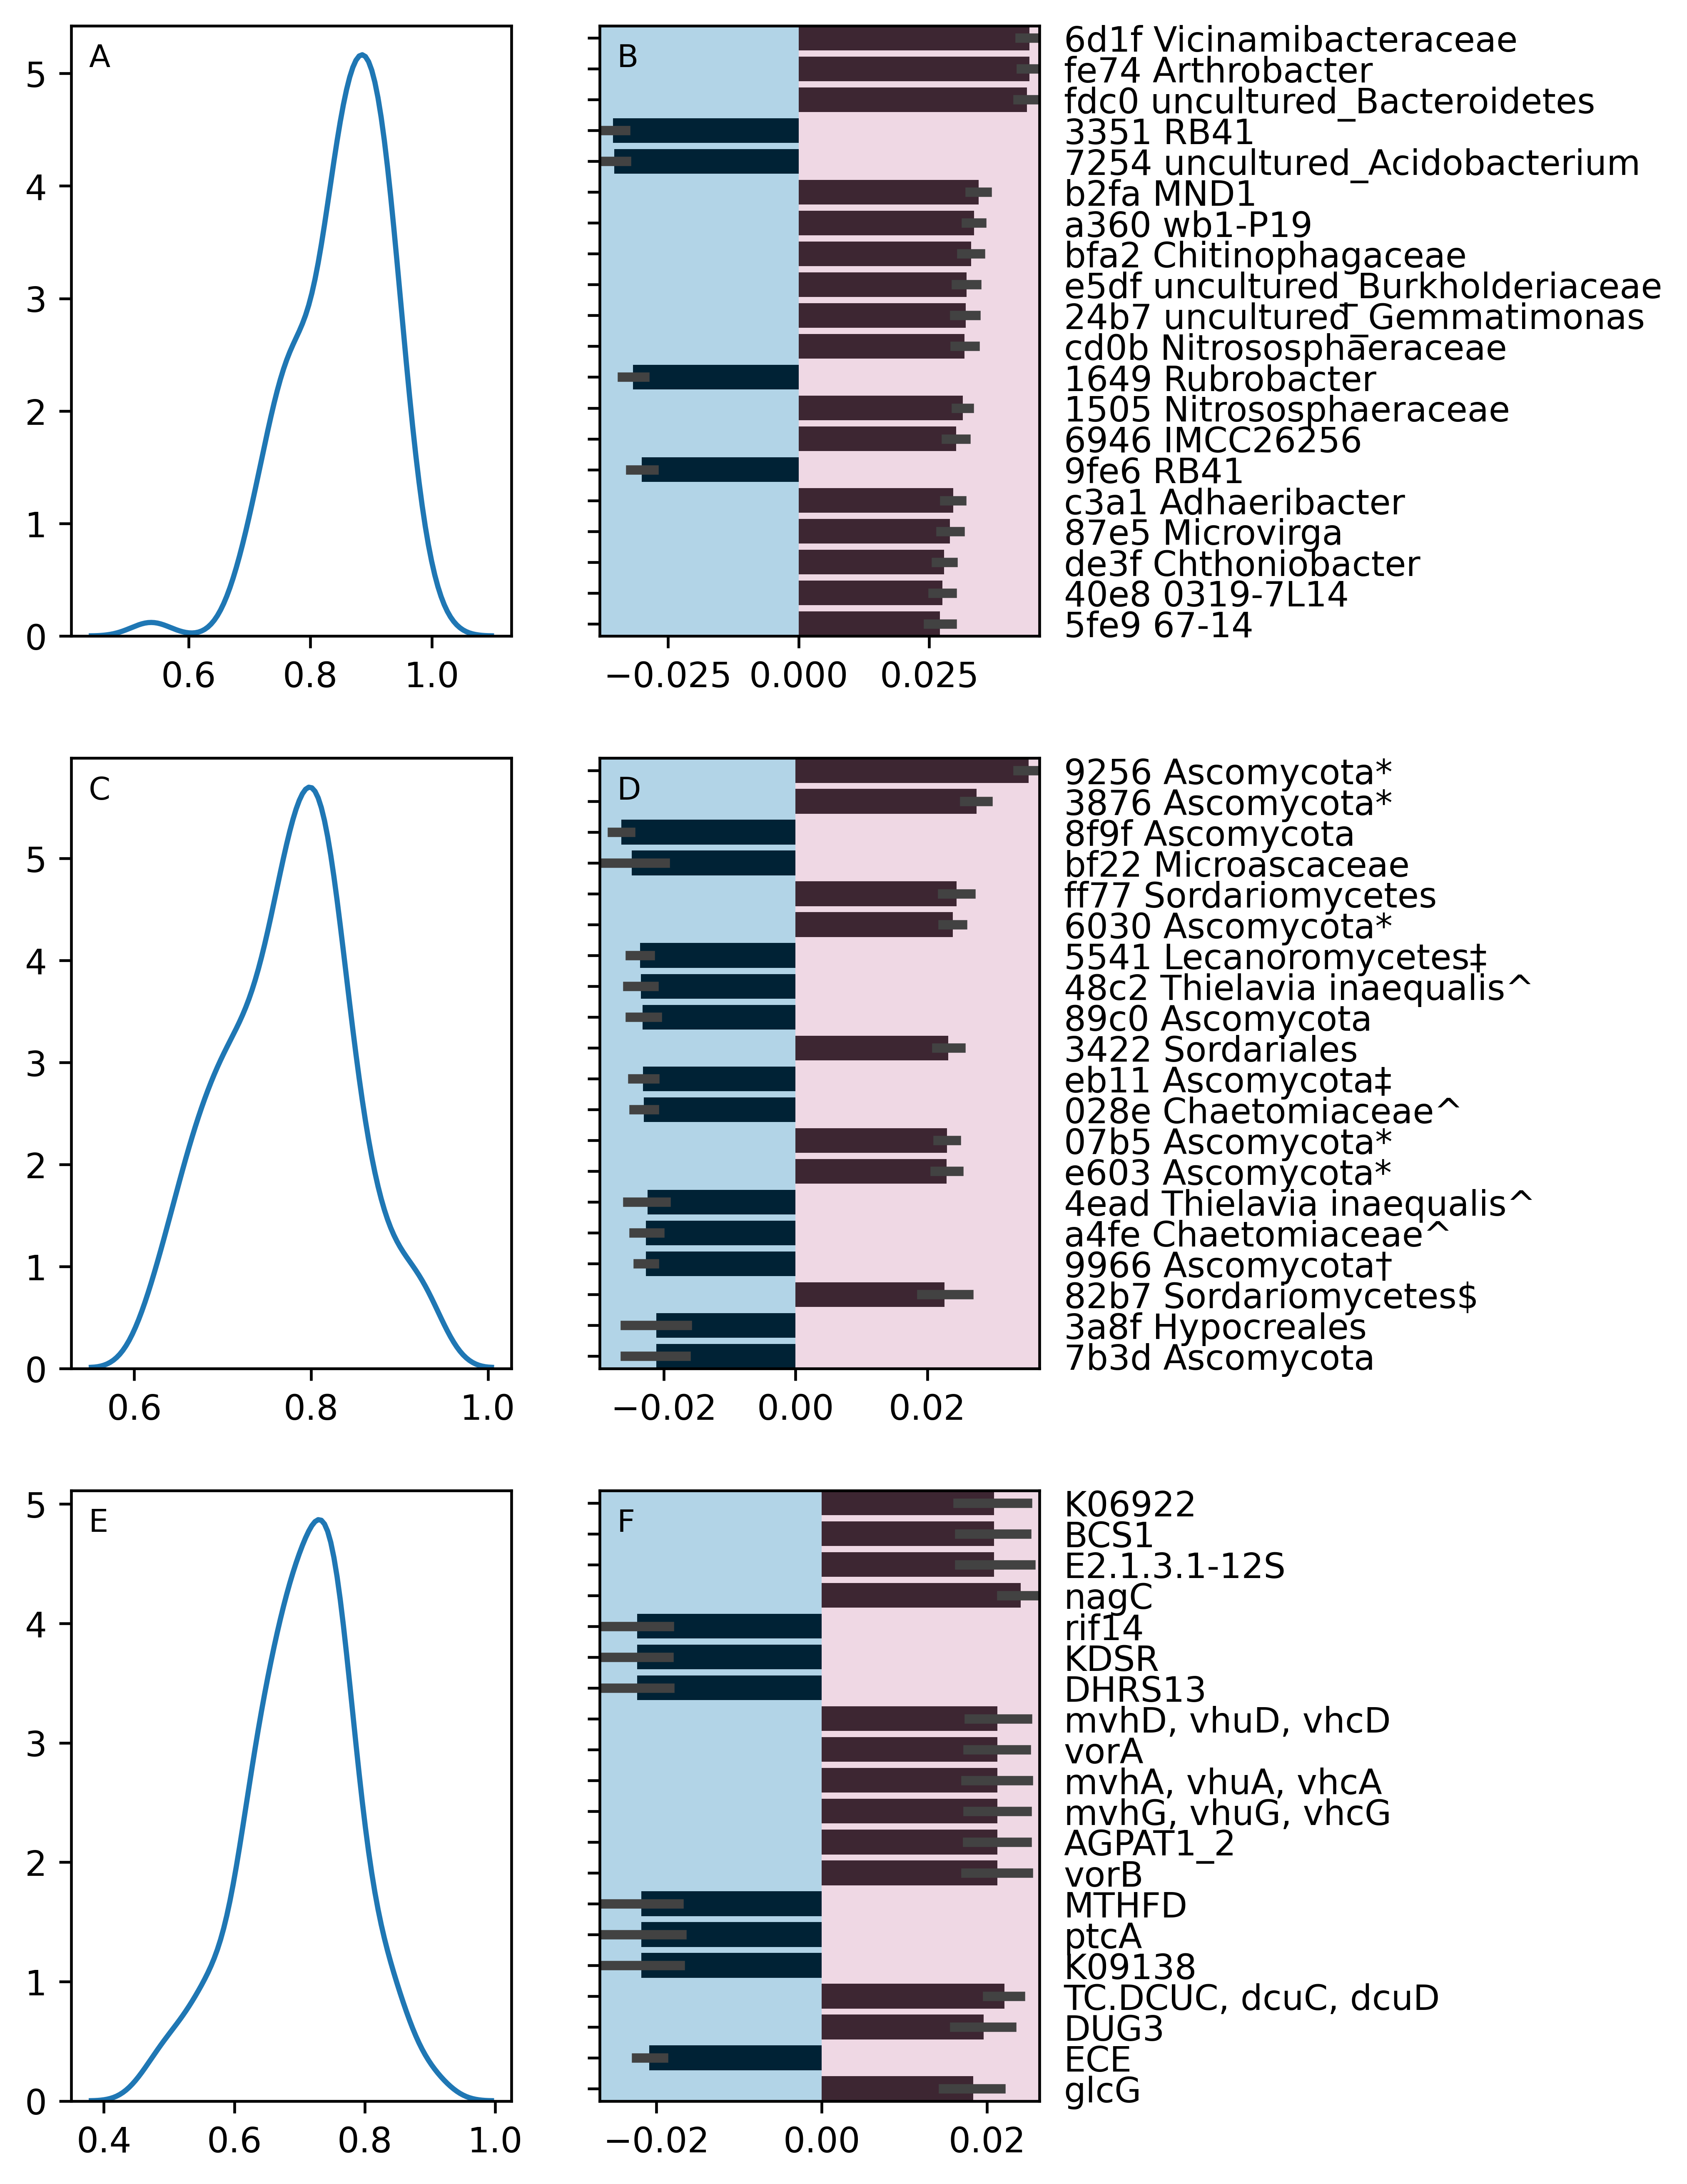

In [23]:
fig, axes = plt.subplots(3,2,dpi=600,figsize=(5,11))

axinds = [0,0,0,1,1,0,1,1,2,0,2,1]
ax_labels = ['A','B','C','D','E','F']

for marker in ['16SrRNA','ITS1']:
    
    qza = 'dada/%s/taxonomy.qza' % marker
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/taxonomy.tsv'
    taxa = pd.read_csv(inf,index_col=0,sep='\t')
    a = !rm -r $digest
    
    R2 = [float(i.rstrip()) for i in open('logistic_regression/%s/regression_coefficients.txt'%marker,'r').readlines()]
    coefficients = pd.read_csv('logistic_regression/%s/coefficients.tsv' % marker, sep='\t', index_col=0)
    
    new_index = []
    if marker == '16SrRNA':
        for asv in coefficients.index:
            levels = taxa.at[asv,'Taxon'].split(';')[::-1]
            while levels[0].split('__')[1]  in ['uncultured','uncultured_bacterium']:
                levels.pop(0)
            new_index.append(asv[:4] + ' ' + levels[0].split('__')[1])
    else:
        for asv in coefficients.index:
            suffix = ''
            if asv[:4] in ['e603','6030','3876','07b5','9256']:
                suffix='*'
            elif asv[:4] in ['4ead', '48c2', '028e', 'a4fe']:
                suffix='^'
            elif asv[:4] in ['8f9e', '9966']:
                suffix='†'
            elif asv[:4] in ['eb11','5541']:
                suffix='‡'
            elif asv[:4] == '82b7':
                suffix='$'
                
            levels = taxa.at[asv,'Taxon'].split(';')[::-1] 
            if levels[0] != 'NA':
                new_index.append(asv[:4] + ' ' + levels[1].split('__')[1]+ ' ' + levels[0].split('__')[1]+suffix)
            else:
                while levels[0] == 'NA':
                    levels.pop(0)
                new_index.append(asv[:4] + ' ' + levels[0].split('__')[1]+suffix)
    coefficients.index = new_index
                               
    ax = axes[axinds.pop(0)][axinds.pop(0)]
    sns.distplot(R2,hist=False,ax=ax)
    ax.annotate(ax_labels.pop(0),xy=(0,1),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=9)
    def get_mean_coef(series):
        return np.average([abs(i) for i in series])
    
    coefficients['Mean'] = coefficients.apply(get_mean_coef,axis=1)  
    coefficients = coefficients.sort_values('Mean',ascending=False)
    coefficients = coefficients.drop('Mean',axis=1)
    coefficients = coefficients.loc[coefficients.index.tolist()[:20],:].transpose()
    ax = axes[axinds.pop(0)][axinds.pop(0)]
    sns.barplot(data=coefficients,ax=ax,orient='h',color='black')
    ax.tick_params(labelleft=False, labelright=True)
    ax.annotate(ax_labels.pop(0),xy=(0,1),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=9)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    ax.axvspan(ax.get_xlim()[0], 0, facecolor='#0072b2', alpha=0.3)
    ax.axvspan(0, ax.get_xlim()[1], facecolor='#cc7fa7', alpha=0.3)

for marker in ['16SrRNA']:
    
    R2 = [float(i.rstrip()) for i in open('picrust/%s/regression_coefficients.txt'%marker,'r').readlines()]
    coefficients = pd.read_csv('picrust/%s/coefficients.tsv' % marker, sep='\t', index_col=0)
                               
    ax = axes[axinds.pop(0)][axinds.pop(0)]
    sns.distplot(R2,hist=False,ax=ax)
    ax.annotate(ax_labels.pop(0),xy=(0,1),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=9)
    
    def get_mean_coef(series):
        return np.average([abs(i) for i in series])
    
    coefficients['Mean'] = coefficients.apply(get_mean_coef,axis=1)  
    coefficients = coefficients.sort_values('Mean',ascending=False).iloc[:20,:].transpose()
    coefficients.drop('Mean')
    
    #new_cols = []
    
    #for col in coefficients:
    #    result = REST.kegg_get(col).readlines()
    #    name = result[1].replace('NAME        ','').rstrip()
    #    description = result[2].replace('DEFINITION  ','').rstrip()
    #    new_cols.append(name)
    coefficients.columns = new_cols

    ax = axes[axinds.pop(0)][axinds.pop(0)]
    sns.barplot(data=coefficients,ax=ax,orient='h',color='black',estimator=np.average)
    ax.tick_params(labelleft=False, labelright=True)
    ax.annotate(ax_labels.pop(0),xy=(0,1),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=9)
    ax.set_ylabel('')
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    ax.axvspan(ax.get_xlim()[0], 0, facecolor='#0072b2', alpha=0.3)
    ax.axvspan(0, ax.get_xlim()[1], facecolor='#cc7fa7', alpha=0.3)
    
fig.savefig('logistic_regression.png',bbox_inches='tight')

### Read the definitions of logistic regression genes

In [135]:
from Bio.KEGG import REST
for marker in ['16SrRNA']:
    
    R2 = [float(i.rstrip()) for i in open('picrust/%s/regression_coefficients.txt'%marker,'r').readlines()]
    coefficients = pd.read_csv('picrust/%s/coefficients.tsv' % marker, sep='\t', index_col=0)
                                   
    def get_mean_coef(series):
        return np.average([abs(i) for i in series])
    
    coefficients['Mean'] = coefficients.apply(get_mean_coef,axis=1)  
    coefficients = coefficients.sort_values('Mean',ascending=False).iloc[:20,:].transpose()
    coefficients.drop('Mean')
    
    new_cols = []
    
    for col in coefficients:
        result = REST.kegg_get(col).readlines()
        name = result[1].replace('NAME        ','').rstrip()
        description = result[2].replace('DEFINITION  ','').rstrip()
        print(col,name, description)
        new_cols.append(name)
    coefficients.columns = new_cols

K06922 K06922 uncharacterized protein
K08900 BCS1 mitochondrial chaperone BCS1
K17489 E2.1.3.1-12S methylmalonyl-CoA carboxyltransferase 12S subunit [EC:2.1.3.1]
K02565 nagC N-acetylglucosamine repressor
K15467 rif14 27-O-demethylrifamycin SV methyltransferase [EC:2.1.1.315]
K04708 KDSR 3-dehydrosphinganine reductase [EC:1.1.1.102]
K11169 DHRS13 dehydrogenase/reductase SDR family member 13 [EC:1.1.-.-]
K14127 mvhD, vhuD, vhcD F420-non-reducing hydrogenase iron-sulfur subunit [EC:1.12.99.- 1.8.98.5 1.8.98.6]
K00186 vorA 2-oxoisovalerate ferredoxin oxidoreductase alpha subunit [EC:1.2.7.7]
K14126 mvhA, vhuA, vhcA F420-non-reducing hydrogenase large subunit [EC:1.12.99.- 1.8.98.5]
K14128 mvhG, vhuG, vhcG F420-non-reducing hydrogenase small subunit [EC:1.12.99.- 1.8.98.5]
K13509 AGPAT1_2 lysophosphatidate acyltransferase [EC:2.3.1.51]
K00187 vorB 2-oxoisovalerate ferredoxin oxidoreductase beta subunit [EC:1.2.7.7]
K00288 MTHFD methylenetetrahydrofolate dehydrogenase (NADP+) / methenyltetra

### Make a tree for important ITS1 ASVs from the logistic regression

In [610]:
coefs_fung = pd.read_csv('logistic_regression/ITS1/coefficients.tsv',sep='\t',index_col=0)
coefs_fung['Mean'] = coefs_fung.mean(axis=1)
coefs_fung = coefs_fung.sort_values('Mean',key=lambda h: abs(h), ascending=False).iloc[:19].index
    
qza = 'dada/ITS1/rep-seqs.qza'
a = !unzip $qza
digest = a[1].split('/')[0].replace('  inflating: ','')
fasta = digest + '/data/dna-sequences.fasta'
records = SeqIO.to_dict(SeqIO.parse(fasta,'fasta'))
for i in list(records.keys()):
    if i not in coefs_fung:
        del records[i]
a = !rm -r $digest

!mkdir phylogenies
SeqIO.write(records.values(),'phylogenies/fungi.fasta','fasta')

mkdir: cannot create directory ‘phylogenies’: File exists


19

In [615]:
from Bio import SeqIO
from gzip import open as gopen

!mkdir phylogenies

a = !makeblastdb -in DB/sh_general_release_dynamic_02.02.2019.fasta -dbtype nucl -out unite -title unite

b = !blastn -query phylogenies/fungi.fasta -out phylogenies/fungi.out -outfmt 6 -max_hsps 1 -max_target_seqs 50 -db unite

from gzip import open as gopen

refs = SeqIO.to_dict(SeqIO.parse('DB/sh_general_release_dynamic_02.02.2019.fasta','fasta'))
 
blast = pd.read_csv('phylogenies/fungi.out',sep='\t',header=None)
blast =set([i for i in blast[1]])
with open('phylogenies/fungi_with_refs.fasta','wt') as hndl:
    for i in blast:
        hndl.write(refs[i].format('fasta'))
    hndl.write(open('phylogenies/fungi.fasta','r').read())
a = !mafft --maxiterate 1000 --localpair --thread 14 phylogenies/fungi_with_refs.fasta > phylogenies/fungi_with_refs.aln.fasta
a = !trimal -in phylogenies/fungi_with_refs.aln.fasta -out phylogenies/fungi_with_refs.trm.fasta -gt 0.1


mkdir: cannot create directory ‘phylogenies’: File exists


In [618]:
ref_records = SeqIO.parse('phylogenies/fungi_with_refs.trm.fasta','fasta')

with open('phylogenies/fungi_with_refs.corrected.fasta','wt') as hndl:
    for r in ref_records:
        if '|' not in r.id:
            hndl.write(r.format('fasta'))
            continue
        r.id = r.id.split('|')[1]
        hndl.write(r.format('fasta'))

a = !raxmlHPC-PTHREADS -s phylogenies/fungi_with_refs.corrected.fasta -f a -x 123 -N 100 -n fungi -m GTRGAMMA -p 456 -T 10 -w /home/amir/Dropbox/DropboxOnBioPC91/GeoDiversity/phylogenies

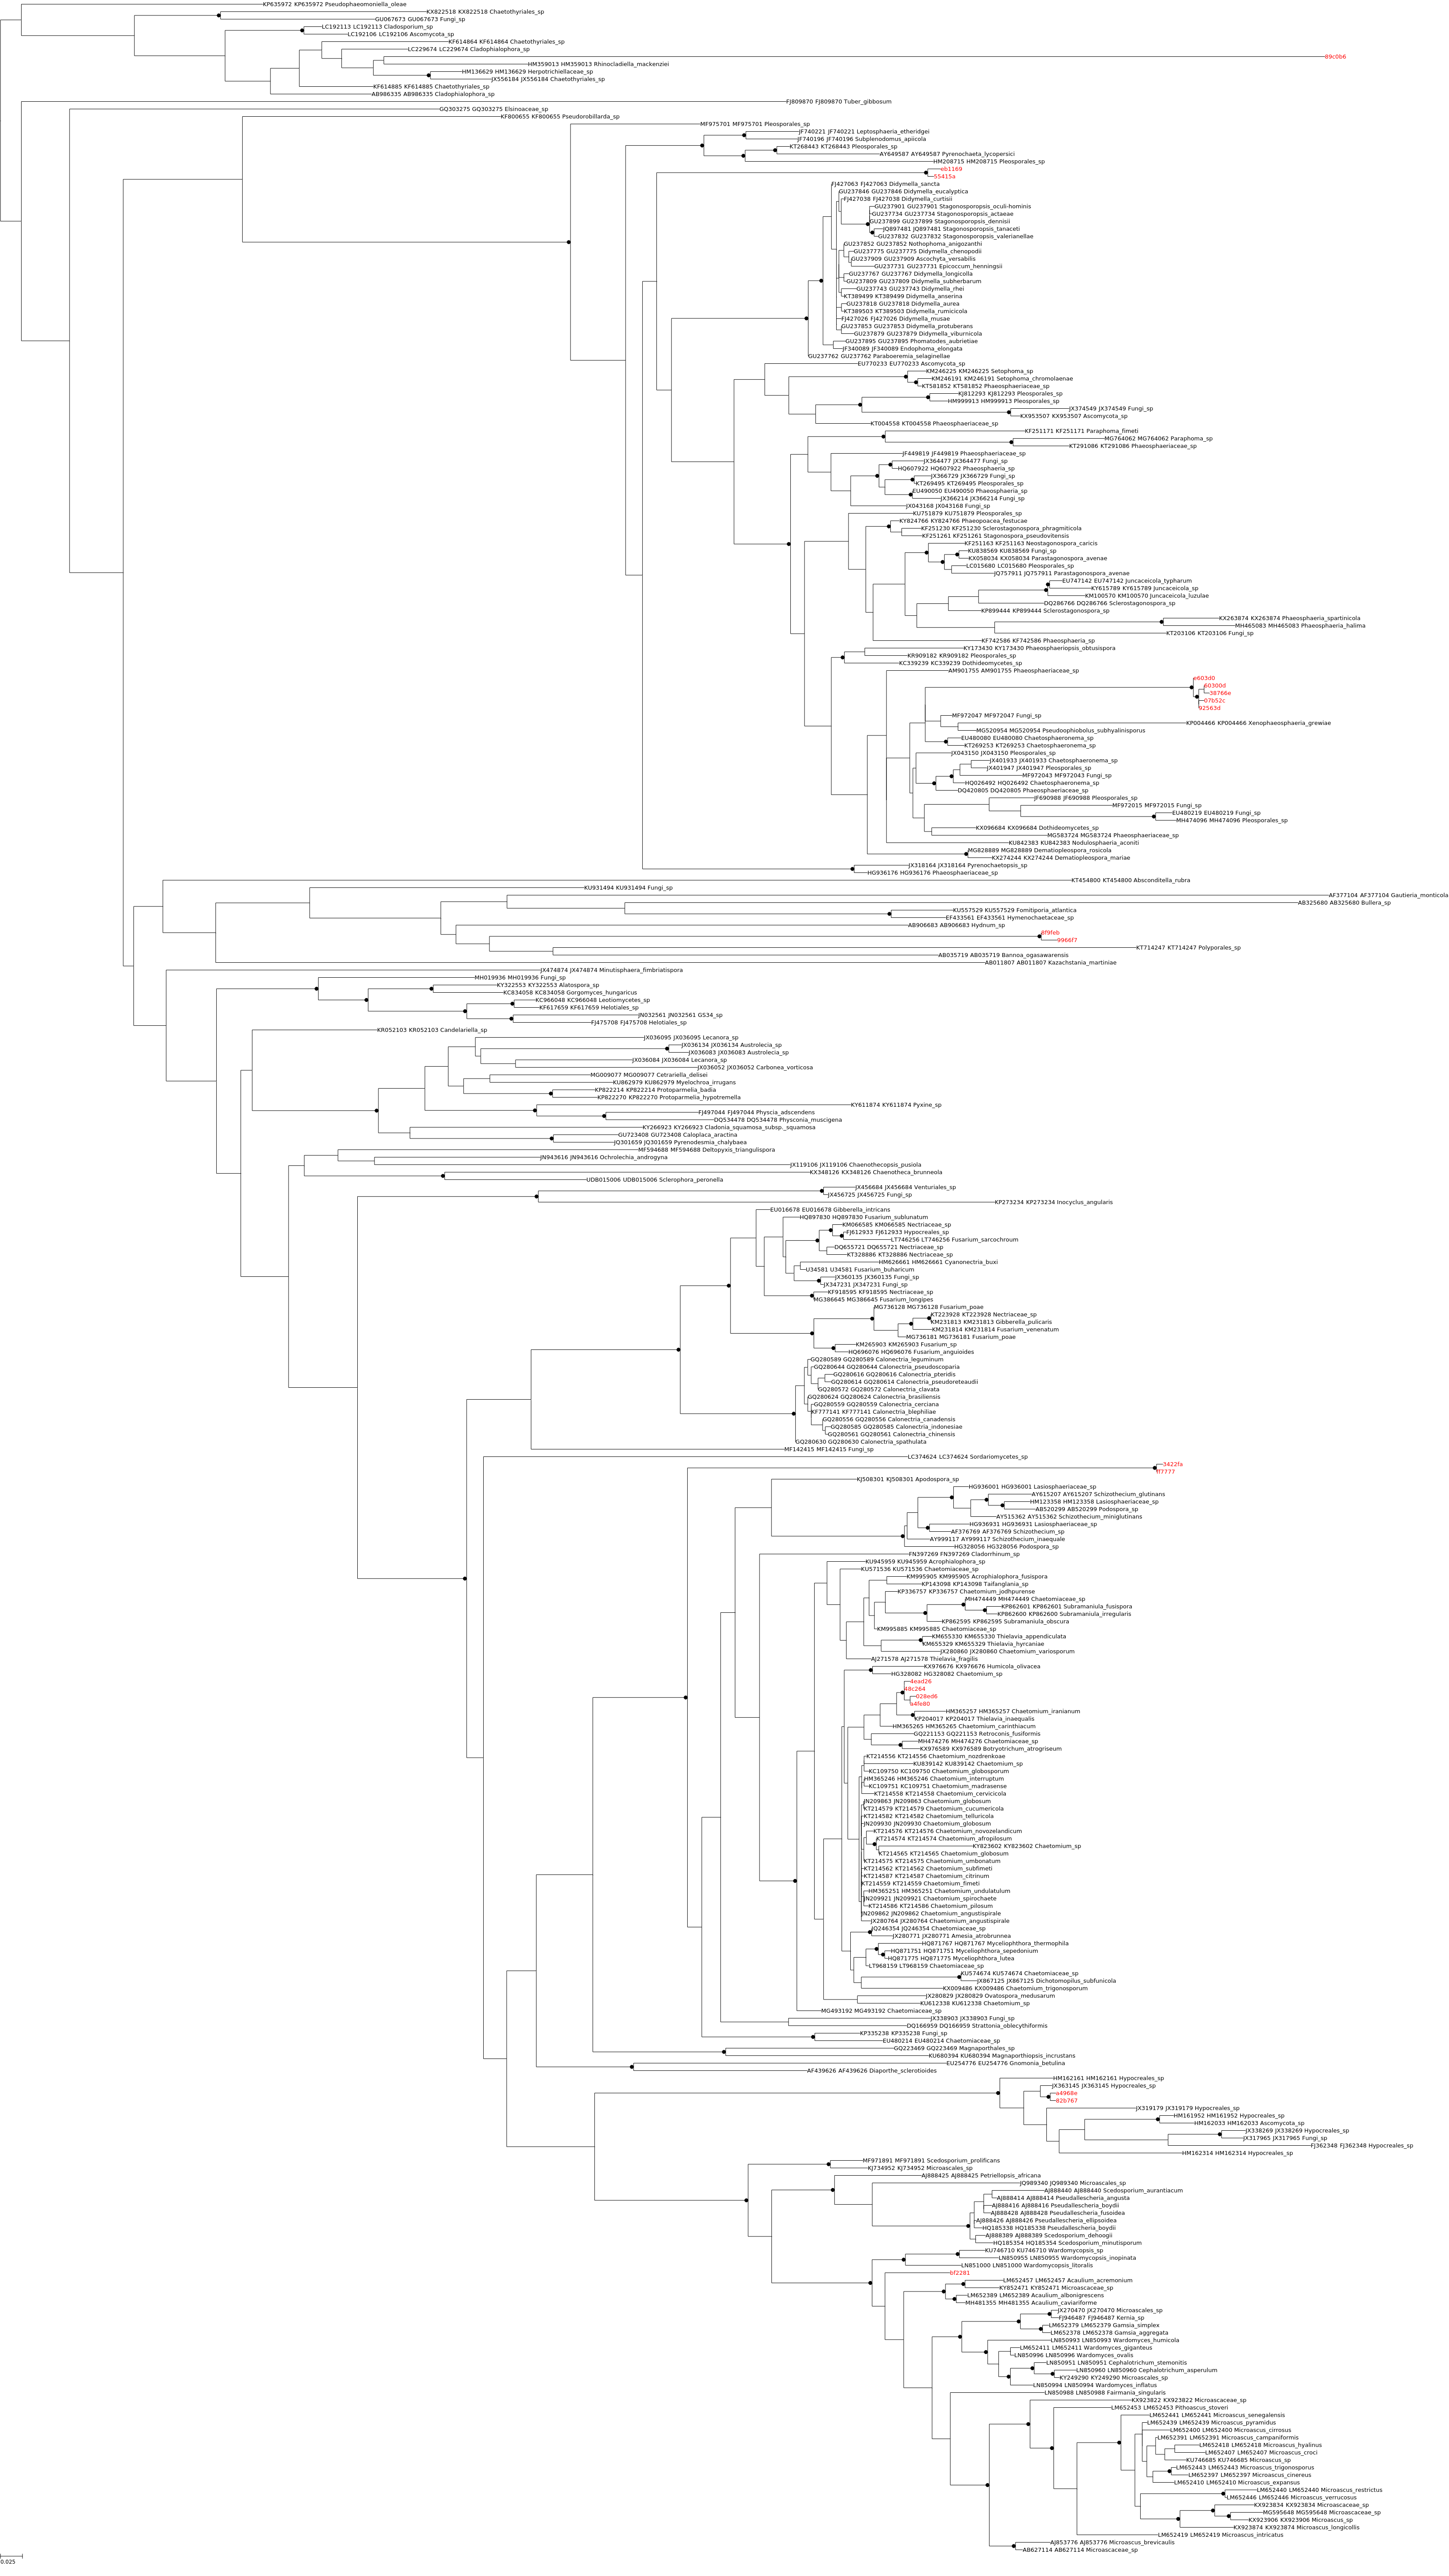

In [3]:
from ete3 import Tree, TextFace, CircleFace, NodeStyle, TreeStyle
from gzip import open as gopen
from Bio import Entrez, SeqIO
Entrez.email = "amir@adssc.org"

refs = SeqIO.to_dict(SeqIO.parse('phylogenies/fungi_with_refs.corrected.fasta','fasta'))

t = Tree('phylogenies/RAxML_bipartitions.fungi')

ns = NodeStyle()
ns['size'] = 0

t.set_outgroup(t.get_midpoint_outgroup())
for n in t.traverse():
    n.set_style(ns)
    if n.is_leaf():
        if len(n.name) < 10:
            color = 'black'
            desc =   refs[n.name].description.split('|')[0]
            n.add_face(TextFace(n.name + ' ',fgcolor='black'),0,position='branch-right')
            n.add_face(TextFace(desc,fgcolor=color),1,position='branch-right')
            #if desc.startswith('Pseudomonas'):
            #    color='blue'
            r = None
            #try:
            #    n.add_face(TextFace(n.name + ' ',fgcolor='black'),0,position='branch-right')
            #    n.add_face(TextFace(desc,fgcolor=color),1,position='branch-right')
            #    handle = Entrez.efetch(db="nucleotide", id=n.name, rettype="gb", retmode="text")
            #    r = SeqIO.read(handle,'gb')
            #    handle.close()
            #except:
            #    r = None
            #if r and 'isolation_source' in r.features[0].qualifiers:
            #    source = r.features[0].qualifiers['isolation_source'][0]
            #    n.add_face(TextFace(' '+source,fgcolor='green'),2,position='branch-right')
        else:
            n.add_face(TextFace(n.name[:6],fgcolor='red'),0,position='branch-right')
    elif n.support > 65:
        n.add_face(CircleFace(4,'black'),0,position='float')
            
ts = TreeStyle()
ts.show_leaf_name = False
ts.scale=2000

t.render('phylogenies/fungi.png',tree_style=ts,dpi=900,w=4000)            
t.render('%%inline',tree_style=ts,dpi=600)

### ANOVA - alpha diversity

In [121]:
!mkdir -p anova/16SrRNA anova/ITS1

for marker in ['16SrRNA','ITS1']:
    qza = 'diversity/%s/faith_pd_vector.qza' % marker
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/alpha-diversity.tsv'
    faithpd = pd.read_csv(inf,index_col=0,sep='\t')
    !rm -r $digest

    metadata = pd.read_csv('%s_metadata.tsv' % marker,sep='\t',index_col=0)
    def get_geo(string):
        return metadata.at[string,'Geodiversity']
    def get_niche(string):
        return str(metadata.at[string,'Niche'])
    def get_part_a(string):
        return str(metadata.at[string,'TubePartA_slope_or_plant'])

    faithpd['Geodiversity'] = faithpd.index.map(get_geo)
    faithpd['Niche'] = faithpd.index.map(get_niche)
    faithpd['Slope'] = faithpd.index.map(get_part_a)
    faithpd.index.name = 'sample-id'
    faithpd.to_csv('anova/%s/faithpd.tsv' % marker,sep='\t')

    table = 'anova/%s/faithpd.tsv' % marker
    qzv = 'anova/%s/faithpd.qzv' % marker
    
    !qiime longitudinal anova \
        --m-metadata-file $table \
        --p-formula "faith_pd ~ Geodiversity + Niche + Slope" \
        --o-visualization $qzv

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/16SrRNA/faithpd.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/ITS1/faithpd.qzv


### Beta diversity test
ANOVA, Within and amnong niches within geodiversity classes

In [2]:
import pandas as pd
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def distance_matrix(qza):
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf,sep='\t',index_col=0)
    !rm -r $digest
    return matrix

narrow1  = pd.DataFrame(columns = ['metric','marker','slope','geodiversity','a','b','niche_a','niche_b','withinamong','distance'])

for marker in ['ITS1','16SrRNA']:
    metadata = pd.read_csv('%s_metadata.tsv' % marker, index_col=0,sep='\t')
    metadata = metadata.loc[metadata.Experiment == 'H_VS_O']
    for metric in ['weighted','unweighted']:
        matrix = distance_matrix('diversity/%s/%s_unifrac_distance_matrix.qza' % (marker,metric))
        samples = metadata.index.tolist()
        samples = [i for i in samples if i in matrix.index.tolist()]
        for i in range(len(samples)):
            for j in range(i+1,len(samples)):
                a = samples[i]
                b = samples[j]
                slope_a = metadata.at[a,'TubePartA_slope_or_plant']
                slope_b = metadata.at[b,'TubePartA_slope_or_plant']
                if slope_a != slope_b:
                    continue
                if metadata.at[a,'Geodiversity'] == 'Homogenous':
                    geodiversity = 'Homogeneous'
                else:
                    geodiversity = 'Heterogeneous'
                niche_a = metadata.at[a,'Niche']
                niche_b = metadata.at[b,'Niche']
                within = None
                if niche_a == niche_b:
                    within = 'within %s' % niche_a
                else:
                    within = 'among niches'
                distance = matrix.at[a,b]
                narrow1.loc[len(narrow1)] = [metric,marker,slope_a,geodiversity,a,b,niche_a,niche_b,within,distance]


In [179]:
for marker in ['16SrRNA','ITS1']:
    for metric in ['weighted','unweighted']:
        narrow1.index.name = 'sample_name'
        narrow1.loc[((narrow1.marker==marker) & (narrow1.metric==metric))].to_csv('anova/%s/%s_within_vs_among_niche.tsv' % (marker,metric),sep='\t')
        table = 'anova/%s/%s_within_vs_among_niche.tsv' % (marker,metric)
        qzv = 'anova/%s/%s_within_vs_among_niche.qzv' % (marker,metric)
        !qiime longitudinal anova \
            --m-metadata-file $table \
            --p-formula "distance ~ withinamong + geodiversity" \
            --o-visualization $qzv

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/16SrRNA/weighted_within_vs_among_niche.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/16SrRNA/unweighted_within_vs_among_niche.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/ITS1/weighted_within_vs_among_niche.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python

AOVA - Within and among biodiversity classes, within niche  
Distances between samples from the same slope were excluded

In [4]:
import pandas as pd
from scipy.stats import mannwhitneyu as mwu
from statsmodels.stats.multitest import multipletests

def distance_matrix(qza):
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf,sep='\t',index_col=0)
    !rm -r $digest
    return matrix

narrow2  = pd.DataFrame(columns = ['metric','marker','niche','a','b','slope_a','geodiversity_a','slope_b','geodiversity_b','withinamong','distance'])

for marker in ['ITS1','16SrRNA']:
    metadata = pd.read_csv('%s_metadata.tsv' % marker, index_col=0,sep='\t')
    metadata = metadata.loc[metadata.Experiment == 'H_VS_O']
    for metric in ['weighted','unweighted']:
        matrix = distance_matrix('diversity/%s/%s_unifrac_distance_matrix.qza' % (marker,metric))
        samples = metadata.index.tolist()
        samples = [i for i in samples if i in matrix.index.tolist()]
        for i in range(len(samples)):
            for j in range(i+1,len(samples)):
                a = samples[i]
                b = samples[j]
                slope_a = metadata.at[a,'TubePartA_slope_or_plant']
                slope_b = metadata.at[b,'TubePartA_slope_or_plant']
                niche_a = metadata.at[a,'Niche']
                niche_b = metadata.at[b,'Niche']
                if slope_a == slope_b:
                    continue
                if niche_a != niche_b:
                    continue
                geodiversity_a = metadata.at[a,'Geodiversity']
                geodiversity_b = metadata.at[b,'Geodiversity']
                within = None
                if geodiversity_a == geodiversity_b:
                    within = 'within %s' % metadata.at[a,'Geodiversity']
                else:
                    within = 'among geodiversity'
                distance = matrix.at[a,b]
                narrow2.loc[len(narrow2)] = [metric,marker,niche_a,a,b,slope_a,geodiversity_a,slope_b,geodiversity_b,within,distance]


In [185]:
for marker in ['16SrRNA','ITS1']:
    for metric in ['weighted','unweighted']:
        narrow2.index.name = 'sample_name'
        narrow2.loc[((narrow2.marker==marker) & (narrow2.metric==metric))].to_csv('anova/%s/%s_within_vs_among_geodiversity.tsv' % (marker,metric),sep='\t')
        table = 'anova/%s/%s_within_vs_among_geodiversity.tsv' % (marker,metric)
        qzv = 'anova/%s/%s_within_vs_among_geodiversity.qzv' % (marker,metric)
        !qiime longitudinal anova \
            --m-metadata-file $table \
            --p-formula "distance ~ withinamong + niche" \
            --o-visualization $qzv

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/16SrRNA/weighted_within_vs_among_geodiversity.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/16SrRNA/unweighted_within_vs_among_geodiversity.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: anova/ITS1/weighted_within_vs_among_geodiversity.qzv
/home/amir/anaconda3/envs/qii

### Pairwise distance distribution plots

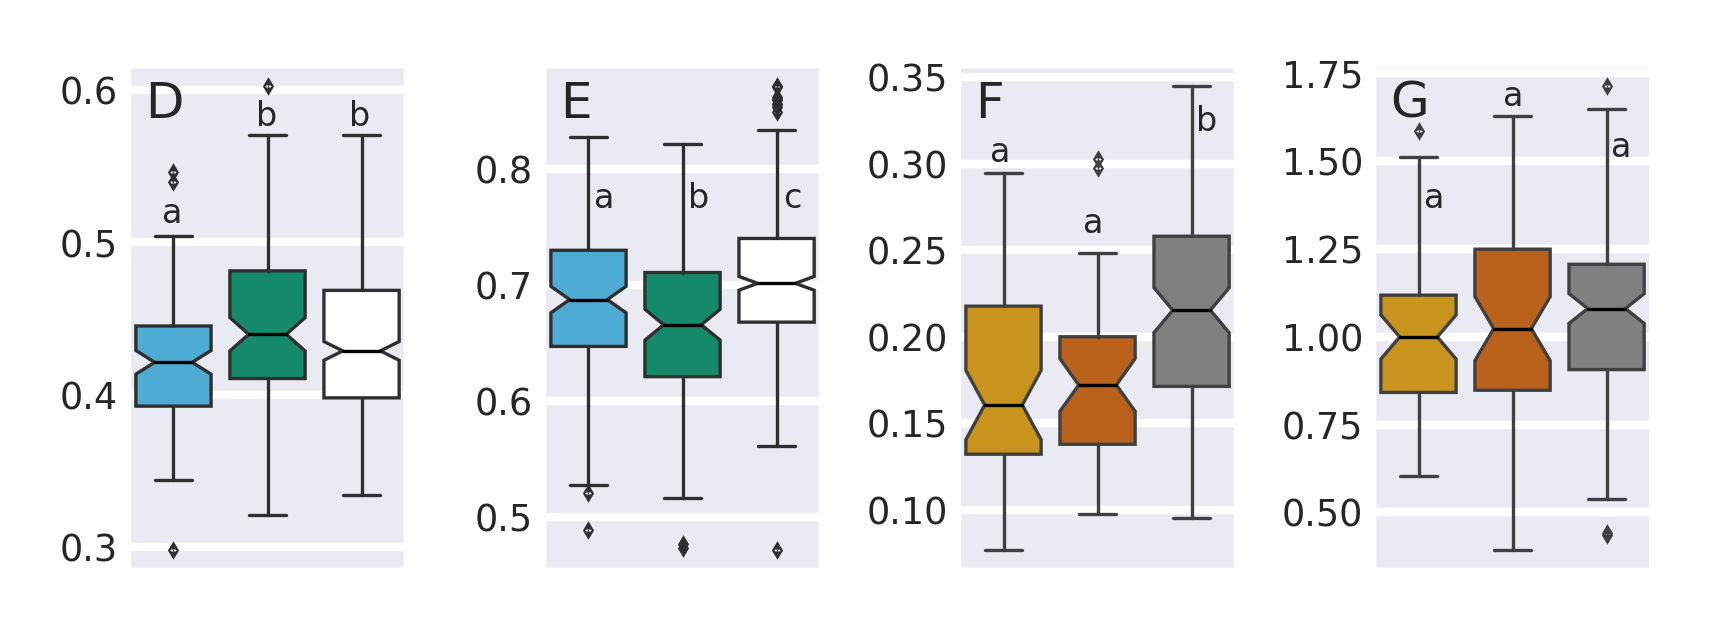

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

narrow1['test'] = 'niches'
narrow2['test'] = 'geodiversity'
sns.set(font_scale=0.4)
fig, axes = plt.subplots(nrows=1,ncols=4,tight_layout=True,dpi=600,figsize=(2.8,1))

axinds = [0,1,2,3]
ax_label = 'D'


for test in ['geodiversity','niches']:
    for marker in ['16SrRNA','ITS1']:
        metric = 'weighted'
        if test == 'geodiversity':
            metric = 'unweighted'
        ax = axes[axinds.pop(0)]
        df = narrow1
        order = ['within Shrub','within Intershrub','among niches']
        color = ['#E69F00','#D55E00','gray']
        swarmcat = 'geodiversity'
        swarmcolors = ['#cc7fa7','#0072b2']
        swarmorder = ['Homogeneous','Heterogeneous']
        swarmmarker = ['s','s']
        hue = 'geodiversity'
        if test == 'geodiversity':
            df = narrow2
            order = ['within Homogenous','within Heterogenous','among geodiversity']
            color = ['#38B4E9','#009E73','white']
            hue = 'niche'
            swarmcat = 'niche'
            swarmorder = ['Shrub','Intershrub']
            swarmcolors = ['darkgray','darkgray']
            swarmmarker = ['o','X']
        df = df.loc[((df.marker==marker)&(df.metric==metric))]
        sns.boxplot(x='withinamong',y='distance',data=df, order=order,ax=ax,palette=color,
                    linewidth=0.4,fliersize=0.2,medianprops={'color':'black'},notch=True)
        #sns.swarmplot(x='withinamong',y='distance',data=df.loc[df[swarmcat]==swarmorder.pop(0)],
        #              order=order,ax=ax,size=1.2,marker=swarmmarker.pop(0),color=swarmcolors.pop(),alpha=0.7)
        #sns.swarmplot(x='withinamong',y='distance',data=df.loc[df[swarmcat]==swarmorder.pop(0)],
        #              order=order,ax=ax,size=1.2,marker=swarmmarker.pop(0),color=swarmcolors.pop(),alpha=0.7)
        ax.set_xticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.yaxis.set_tick_params(pad=-5)
        ax.annotate(ax_label,xy=(-0.08,1.05),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=6)
        if ax_label=='F':
            ax.annotate('a',xy=(-0.03,0.94),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('a',xy=(0.3,0.8),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('b',xy=(0.7,1.0),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
        if ax_label=='G':
            ax.annotate('a',xy=(0.04,0.85),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('a',xy=(0.32,1.05),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('a',xy=(0.7,0.95),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
        if ax_label=='D':
            ax.annotate('a',xy=(-0.02,0.82),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('b',xy=(0.31,1.01),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('b',xy=(0.64,1.01),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            #ax.annotate('^',xy=(0.85,0.12),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=6)
        if ax_label=='E':
            ax.annotate('a',xy=(0.04,0.85),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('b',xy=(0.37,0.85),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
            ax.annotate('c',xy=(0.71,0.85),xycoords="axes fraction",xytext=(5,-5),textcoords="offset points",ha="left",va="top",size=4)
        ax_label = chr(ord(ax_label) + 1) 
            
fig.savefig('unifrac_boxplots_subset.png',bbox_inches='tight')    

### Ancom - level 6

In [24]:

for marker in ['16SrRNA','ITS1']:
    
    outdir = 'ancom/%s' % marker
    !mkdir -p $outdir
    
    table_H_vs_H = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qza' % marker
    table_Hetro = 'filtered_tables/%s/filtered_table.hetero.qza' % marker
    table_Homo = 'filtered_tables/%s/filtered_table.homo.qza' % marker
    ancom_H_vs_H = 'ancom/%s/ancom_H_vs_H.qzv' % marker
    ancom_Hetro = 'ancom/%s/ancom_Hetro.qzv' % marker
    ancom_Homo = 'ancom/%s/ancom_Homo.qzv' % marker
    metadata = '%s_metadata.tsv' % marker
    taxonomy = 'dada/%s/taxonomy.qza' % marker

    !qiime taxa collapse \
      --i-table $table_H_vs_H \
      --i-taxonomy $taxonomy \
      --p-level 6 \
      --o-collapsed-table temp.qza

    !qiime composition add-pseudocount \
      --i-table temp.qza \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Geodiversity \
      --o-visualization $ancom_H_vs_H
    
    !rm temp.qza

    !qiime taxa collapse \
      --i-table $table_Hetro \
      --i-taxonomy $taxonomy \
      --p-level 6 \
      --o-collapsed-table temp.qza
    
    !qiime composition add-pseudocount \
      --i-table temp.qza \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Niche \
      --o-visualization $ancom_Hetro
    
    !rm temp.qza

    !qiime taxa collapse \
      --i-table $table_Homo \
      --i-taxonomy $taxonomy \
      --p-level 6 \
      --o-collapsed-table temp.qza

    !qiime composition add-pseudocount \
      --i-table temp.qza \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Niche \
      --o-visualization $ancom_Homo
    
    !rm temp.qza

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Composition] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: ancom/16SrRNA/ancom_H_vs_H.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.tes

### ANCOM level 4

In [25]:
for marker in ['16SrRNA','ITS1']:
    
    outdir = 'ancom_l4/%s' % marker
    !mkdir -p $outdir
    
    table_H_vs_H = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qza' % marker
    table_Hetro = 'filtered_tables/%s/filtered_table.hetero.qza' % marker
    table_Homo = 'filtered_tables/%s/filtered_table.homo.qza' % marker
    ancom_H_vs_H = 'ancom_l4/%s/ancom_H_vs_H.qzv' % marker
    ancom_Hetro = 'ancom_l4/%s/ancom_Hetro.qzv' % marker
    ancom_Homo = 'ancom_l4/%s/ancom_Homo.qzv' % marker
    metadata = '%s_metadata.tsv' % marker
    taxonomy = 'dada/%s/taxonomy.qza' % marker

    !qiime taxa collapse \
      --i-table $table_H_vs_H \
      --i-taxonomy $taxonomy \
      --p-level 4 \
      --o-collapsed-table temp.qza

    !qiime composition add-pseudocount \
      --i-table temp.qza \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Geodiversity \
      --o-visualization $ancom_H_vs_H
    
    !rm temp.qza

    !qiime taxa collapse \
      --i-table $table_Hetro \
      --i-taxonomy $taxonomy \
      --p-level 4 \
      --o-collapsed-table temp.qza
    
    !qiime composition add-pseudocount \
      --i-table temp.qza \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Niche \
      --o-visualization $ancom_Hetro
    
    !rm temp.qza

    !qiime taxa collapse \
      --i-table $table_Homo \
      --i-taxonomy $taxonomy \
      --p-level 4 \
      --o-collapsed-table temp.qza

    !qiime composition add-pseudocount \
      --i-table temp.qza \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Niche \
      --o-visualization $ancom_Homo
    
    !rm temp.qza

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Composition] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: ancom_l4/16SrRNA/ancom_H_vs_H.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.

k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales

### ANCOM - ASV

In [26]:
for marker in ['16SrRNA','ITS1']:
    
    outdir = 'ancom_asvs/%s' % marker
    !mkdir -p $outdir
    
    table_H_vs_H = 'filtered_tables/%s/filtered_table.Homo_VS_Hetero.qza' % marker
    table_Hetro = 'filtered_tables/%s/filtered_table.hetero.qza' % marker
    table_Homo = 'filtered_tables/%s/filtered_table.homo.qza' % marker
    ancom_H_vs_H = 'ancom_asvs/%s/ancom_H_vs_H.qzv' % marker
    ancom_Hetro = 'ancom_asvs/%s/ancom_Hetro.qzv' % marker
    ancom_Homo = 'ancom_asvs/%s/ancom_Homo.qzv' % marker
    metadata = '%s_metadata.tsv' % marker
    taxonomy = 'dada/%s/taxonomy.qza' % marker

    !qiime composition add-pseudocount \
      --i-table $table_H_vs_H \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Geodiversity \
      --o-visualization $ancom_H_vs_H
    
    !rm temp.qza

    !qiime composition add-pseudocount \
      --i-table $table_Hetro \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Niche \
      --o-visualization $ancom_Hetro
    
    !rm temp.qza

    !qiime composition add-pseudocount \
      --i-table $table_Homo \
      --o-composition-table temp.qza

    !qiime composition ancom \
      --i-table temp.qza \
      --m-metadata-file $metadata \
      --m-metadata-column Niche \
      --o-visualization $ancom_Homo
    
    !rm temp.qza

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Composition] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: ancom_asvs/16SrRNA/ancom_H_vs_H.qzv
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Composition] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.u

In [31]:
from qiime2 import Artifact
ssu_taxa = Artifact.load('dada/16SrRNA/taxonomy.qza').view(pd.DataFrame) 
print(ssu_taxa.at['6d1ff6c199a5f48c41d2ac9691e5903b','Taxon'])
its_taxa = Artifact.load('dada/ITS1/taxonomy.qza').view(pd.DataFrame) 
print(its_taxa.at['92563d0ceba4a3712941e200e032a98a','Taxon'])

d__Bacteria; p__Acidobacteriota; c__Vicinamibacteria; o__Vicinamibacterales; f__Vicinamibacteraceae; g__Vicinamibacteraceae
k__Fungi;p__Ascomycota;NA;NA;NA;NA;NA


### ASV to taxon ratio

In [43]:
import pandas as pd
from qiime2 import Artifact
from itertools import chain

!mkdir ASV_to_taxa_ratio

core_asv_and_tax_count = pd.DataFrame(columns=['marker','geodiversity','feature_type','count','class_name'])

for marker in ['16SrRNA','ITS1']:
    metadata = pd.read_csv('%s_metadata.tsv' % marker,sep='\t',index_col=0)
    asv_table = Artifact.load('diversity/%s/rarefied_table.qza' % marker).view(pd.DataFrame)
    metadata = metadata.loc[asv_table.index,:]
    intab = 'diversity/%s/rarefied_table.qza' % marker
    taxonomy = 'dada/%s/taxonomy.qza' % marker
    if marker == '16SrRNA':
        level = 6
    elif marker == 'ITS1':
        level = 5
    !qiime taxa collapse \
      --i-table $intab \
      --i-taxonomy $taxonomy \
      --p-level $level \
      --o-collapsed-table temp.qza
    taxa_table = Artifact.load('temp.qza').view(pd.DataFrame)
    !rm temp.qza
    
    core_asvs = {}
    core_taxa = {}
    
    for geo in set(metadata.Geodiversity):
        core_asvs[geo] = {}
        core_taxa[geo] = {}
        for niche in set(metadata.Niche):
            for slope in set(metadata.loc[((metadata.Geodiversity==geo)&(metadata.Niche==niche))].TubePartA_slope_or_plant):
                core_asvs[geo][slope+'_'+niche] = []
                core_taxa[geo][slope+'_'+niche] = []
                asv_subtab = asv_table.loc[metadata.loc[((metadata.Geodiversity==geo)&(metadata.Niche==niche)&(metadata.TubePartA_slope_or_plant==slope))].index,:]
                taxa_subtab = taxa_table.loc[metadata.loc[((metadata.Geodiversity==geo)&(metadata.Niche==niche)&(metadata.TubePartA_slope_or_plant==slope))].index,:]
                for asv in asv_subtab:
                    if [i>0 for i in asv_subtab[asv]].count(True)/len(asv_subtab[asv]) >= 0.8:
                        core_asvs[geo][slope+'_'+niche].append(asv)
                for taxon in taxa_subtab:
                    if taxon.endswith('NA'):
                        continue
                    if [i>0 for i in taxa_subtab[taxon]].count(True)/len(taxa_subtab[taxon]) >= 0.8:
                        core_taxa[geo][slope+'_'+niche].append(taxon)
    for geo in core_asvs:
        g = 'Homogeneous'
        if geo == 'Heterogenous':
            g = 'Heterogeneous'
        for c in core_asvs[geo]:
            core_asv_and_tax_count.loc[len(core_asv_and_tax_count)] = [marker,g,'ASV',len(core_asvs[geo][c]),c]
            core_asv_and_tax_count.loc[len(core_asv_and_tax_count)] = [marker,g,'taxon',len(core_taxa[geo][c]),c]
            core_asv_and_tax_count.loc[len(core_asv_and_tax_count)] = [marker,g,'ratio',len(core_asvs[geo][c])/len(core_taxa[geo][c]),c]
    
core_asv_and_tax_count.to_csv('ASV_to_taxa_ratio/core_asv_and_tax_count.tsv',sep='\t')


mkdir: cannot create directory ‘ASV_to_taxa_ratio’: File exists
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: temp.qza
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: temp.qza


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: ASV_to_taxa_ratio/16SrRNA_anova.qzv


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: ASV_to_taxa_ratio/ITS1_anova.qzv


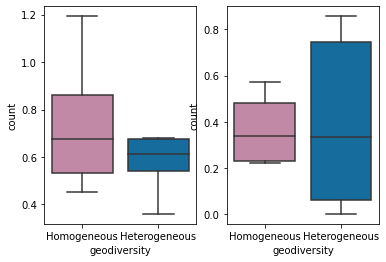

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
%matplotlib inline

core_asv_and_tax_count = pd.read_csv('ASV_to_taxa_ratio/core_asv_and_tax_count.tsv',sep='\t',index_col=0)
fig, axes = plt.subplots(ncols=2)
indices = [0,1]

for marker in ['16SrRNA','ITS1']:
    df = core_asv_and_tax_count.loc[(
        (core_asv_and_tax_count.marker==marker)&(core_asv_and_tax_count.feature_type=='ratio')
    )]
    df.index.name = 'sample_name'
    def get_slope(string):
        return string.split('_')[0]
    def get_niche(string):
        return string.split('_')[1]
    df['niche'] = df.class_name.apply(get_niche)
    df['slope'] = df.class_name.apply(get_slope)
    df.to_csv('temp.tsv',sep='\t')
    outf = 'ASV_to_taxa_ratio/%s_anova.qzv' % marker
    !qiime longitudinal anova \
        --m-metadata-file temp.tsv \
        --p-formula "count ~ geodiversity + niche + slope" \
        --o-visualization $outf
    !rm temp.tsv
    ax = axes[indices.pop(0)]
    sns.boxplot(x='geodiversity',y='count',
                data=core_asv_and_tax_count.loc[((core_asv_and_tax_count.feature_type=='ratio')&(core_asv_and_tax_count.marker==marker))],
                ax=ax,order=['Homogeneous','Heterogeneous'],
                palette=['#cc7fa7','#0072b2'],
                showfliers=False)